In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.express as px
import itertools
import warnings
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
sns.set(style='whitegrid')

In [106]:
df = pd.read_csv(r'siniestros_con_hipotesis.csv', index_col=0)

In [110]:
df = df[df['ANO']>=2016]

In [111]:
df['FECHA'] = pd.to_datetime(df['FECHA'])
df.head()

,CODIGO_SINIESTRO,FECHA,HORA,GRAVEDAD,CLASE,CHOQUE_CON,OBJETO_FIJO,DIRECCION,TOTAL_MUERTOS,TOTAL_HERIDOS,...,DESCRIPCION2,CODIGO_CAUSA3,DESCRIPCION3,CODIGO_CAUSA4,DESCRIPCION4,Hora,Dia,Mes,ILESOS,ANO
31341,4433477,2016-01-01,11:40:00,Con Heridos,Otro,NaN,NaN,CL 80-KR 120 02,0,1,...,NaN,NaN,NaN,NaN,NaN,11,4,1,1.0,2016
31342,4433480,2016-01-01,02:15:00,Con Heridos,Choque,Vehiculo,NaN,KR 17M-CL 69A S 02,0,1,...,ADELANTAR EN ZONA PROHIBIDA,NaN,NaN,NaN,NaN,2,4,1,0.0,2016
31343,4433505,2016-01-01,14:45:00,Solo Daños,Choque,Objeto Fijo,Vehiculo estacionado,KR 12A-CL 43A ES 23,0,0,...,NaN,NaN,NaN,NaN,NaN,14,4,1,1.0,2016
31344,4433506,2016-01-01,12:40:00,Solo Daños,Choque,Vehiculo,NaN,AV AVENIDA BOYACA-CL 134 02,0,0,...,NaN,NaN,NaN,NaN,NaN,12,4,1,2.0,2016
31345,4433509,2016-01-01,17:00:00,Solo Daños,Choque,Vehiculo,NaN,KR 45-CL 185 02,0,0,...,NaN,NaN,NaN,NaN,NaN,17,4,1,2.0,2016


In [112]:
siniestros = pd.DataFrame(df.groupby('FECHA')['CODIGO_SINIESTRO'].count().reset_index(name='Cantidad_siniestros'))

In [113]:
siniestros = siniestros.sort_values(by=['FECHA'])
siniestros.tail()

,FECHA,Cantidad_siniestros
1456,2019-12-27,83
1457,2019-12-28,63
1458,2019-12-29,50
1459,2019-12-30,79
1460,2019-12-31,63


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


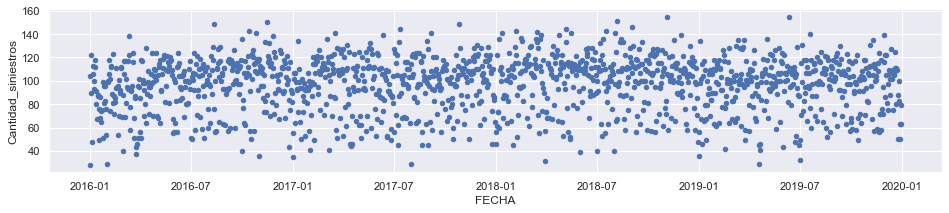

In [114]:
sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(16,3)})
ax = siniestros.plot(kind='scatter', x='FECHA', y='Cantidad_siniestros')


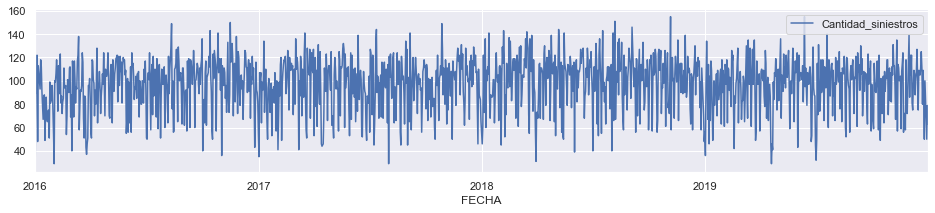

In [115]:
sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(16,3)})
ax = siniestros.plot(kind='line', x='FECHA', y='Cantidad_siniestros')

In [116]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [117]:
accidentes = pd.DataFrame(siniestros.set_index('FECHA'))
accidentes

,Cantidad_siniestros
FECHA,
2016-01-01,28
2016-01-02,104
2016-01-03,90
2016-01-04,122
2016-01-05,48
...,...
2019-12-27,83
2019-12-28,63
2019-12-29,50


In [118]:
y = pd.DataFrame(accidentes['Cantidad_siniestros'].resample('MS').mean())
y.head()

,Cantidad_siniestros
FECHA,
2016-01-01,83.096774
2016-02-01,91.551724
2016-03-01,87.032258
2016-04-01,95.533333
2016-05-01,101.677419


In [119]:
len(y)

48

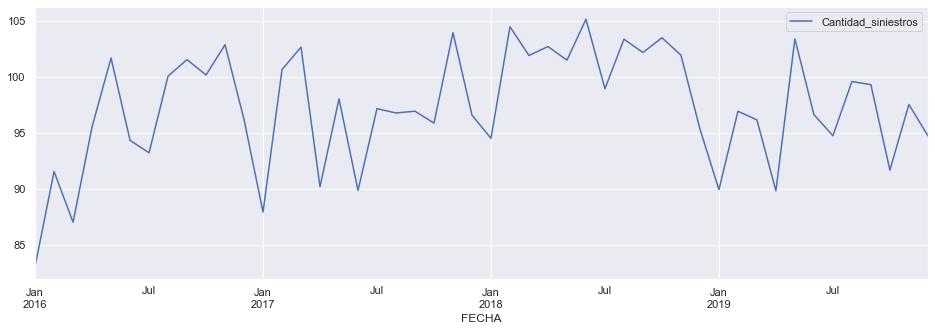

In [120]:
y.plot(figsize=(16, 5))
plt.show()

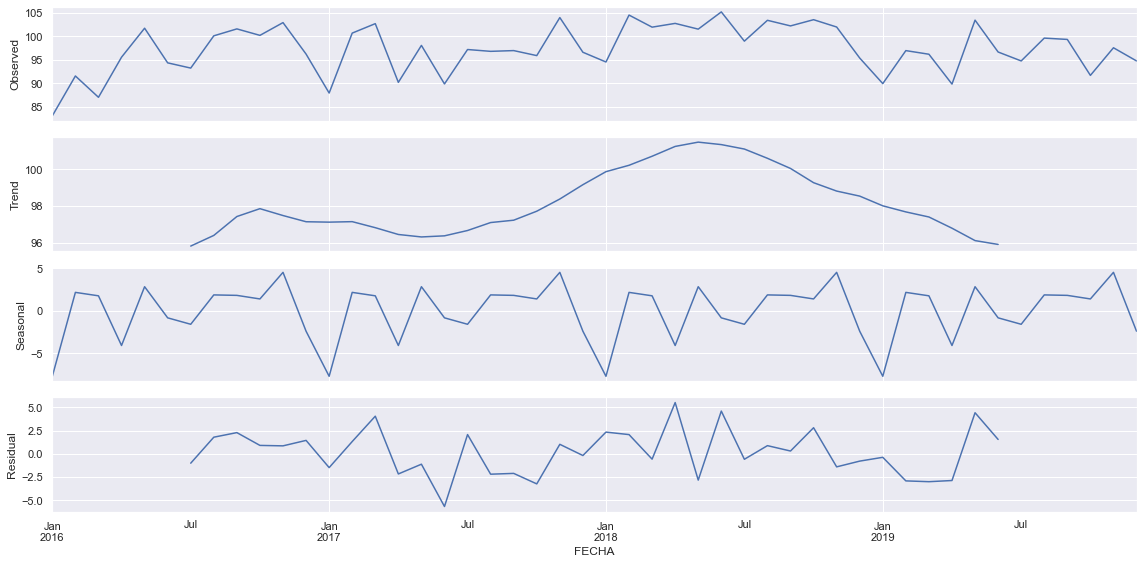

In [121]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 16, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Lambda Value 6.062039200562408


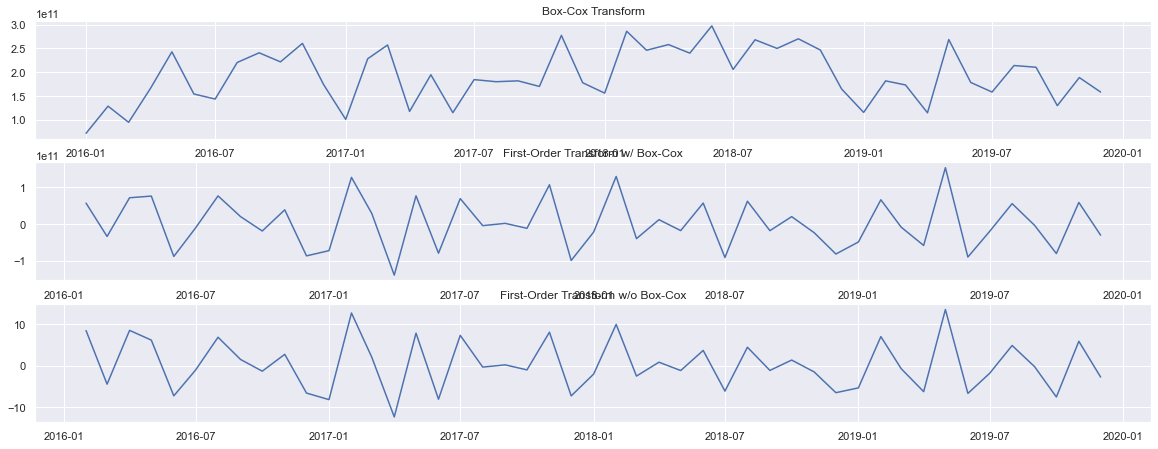

In [122]:
y['bc_production'], lamb = stats.boxcox(y.Cantidad_siniestros)
y['df1_production'] = y['bc_production'].diff()
y['df_production'] = y['Cantidad_siniestros'].diff()
fig = plt.figure(figsize=(20,10))

bc = plt.subplot(411)
bc.plot(y.bc_production)
bc.title.set_text('Box-Cox Transform')
df1 = plt.subplot(412)
df1.plot(y.df1_production)
df1.title.set_text('First-Order Transform w/ Box-Cox')
df2 = plt.subplot(413)
df2.plot(y.df_production)
df2.title.set_text('First-Order Transform w/o Box-Cox')

y.bc_production.dropna(inplace=True)
y.df1_production.dropna(inplace=True)
y.df_production.dropna(inplace=True)

print(f'Lambda Value {lamb}')

ValueError: operands could not be broadcast together with shapes (49,) (46,) (49,) 

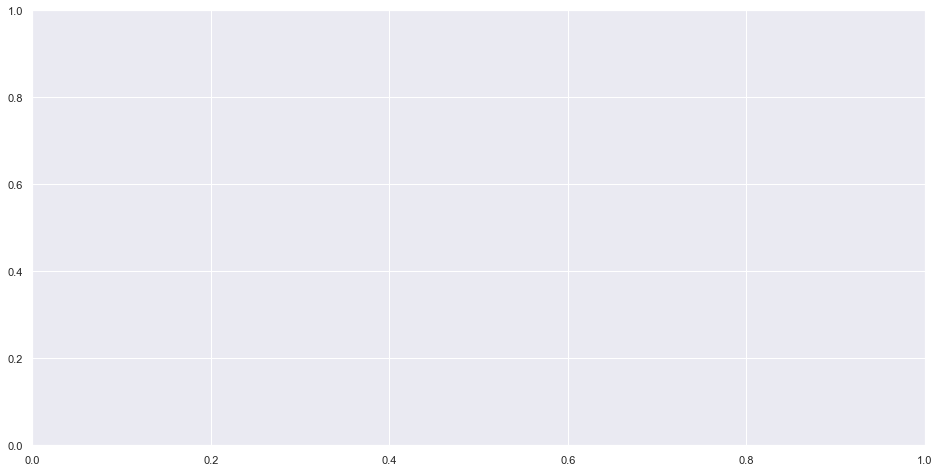

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
f_acf = plot_acf(y['df_production'],ax = plt.gca(), lags=50)
f_pacf = plot_acf(y['df_production'], ax = plt.gca(), lags=50)
f_acf.set_figheight(10)
f_acf.set_figwidth(15)
f_pacf.set_figheight(10)
f_pacf.set_figwidth(15)
plt.show()

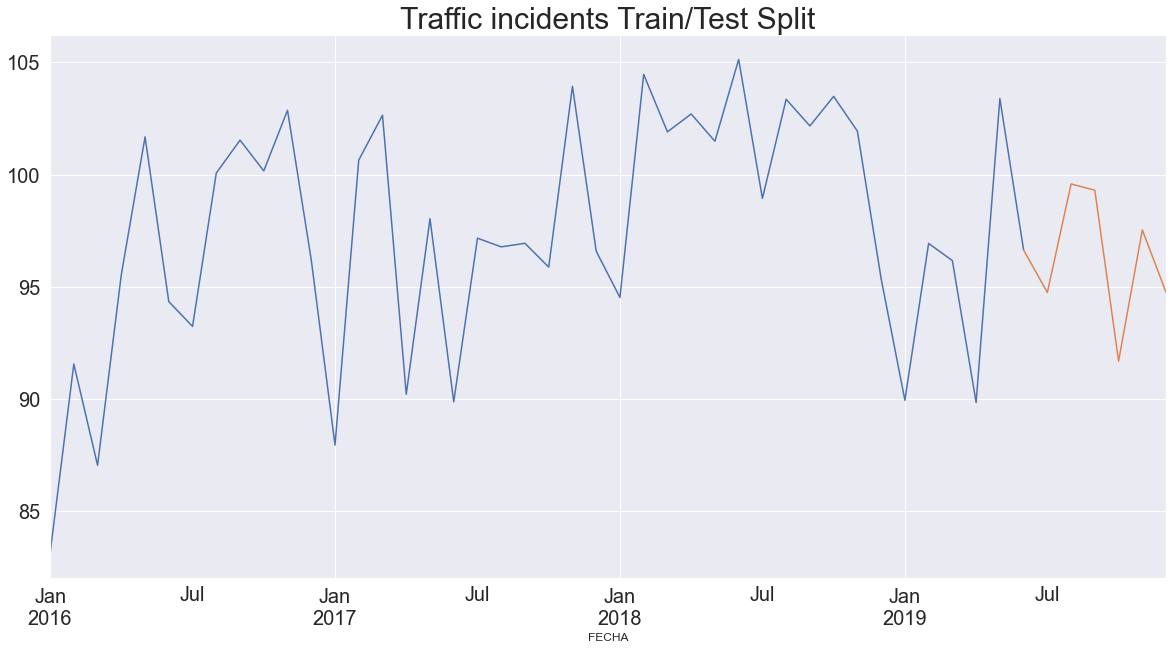

In [125]:
split_date = '2019-06-01'
train = y['Cantidad_siniestros'].loc[:split_date]
test = y['Cantidad_siniestros'].loc[split_date:]
train.plot(figsize=(20, 10), fontsize=20)
plt.title('Traffic incidents Train/Test Split', fontsize=30)
test.plot()
plt.show()

In [126]:
model = sm.tsa.statespace.SARIMAX(train, freq='MS', order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))
model_fit = model.fit(disp=False) 

In [ ]:
fcast_len = len(test)
fcast = model_fit.forecast(fcast_len)
mse = mean_squared_error(test, fcast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, fcast)
plt.figure(figsize=(20, 10))
plt.title('Traffic incident Forecast', fontsize=30)
plt.plot(train, label='Train')
plt.plot(fcast, label='Forecast')
plt.plot(test, label='Test')

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
plt.legend(fontsize=25)
plt.show()

In [96]:
def rolling_forecast(train, test, order, season):
    history = [x for x in train]
    model = sm.tsa.statespace.SARIMAX(history, order= order, seasonal_order= season)
    model_fit = model.fit(disp=False)
    predictions = []
    results = {}
    yhat = model_fit.forecast()[0]

    predictions.append(yhat)
    history.append(test[0])
    for i in range(1, len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order= order, seasonal_order= season)
        model_fit = model.fit(disp=False)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        obs = test[i]
        history.append(obs)
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    rmse = math.sqrt(mse)
    predictions = pd.Series(predictions, index=test.index)
    results['predictions'] = predictions
    results['mse'] = mse
    results['rmse'] = rmse
    results['mae'] = mae
    return results

In [97]:
rolling_fcast = rolling_forecast(train, test, (1, 1, 1), (1, 0, 0, 12))

Mean Squared Error: 22.83869986012054
Root Mean Squared Error: 4.778985233302206
Mean Absolute Error: 3.816854279865275


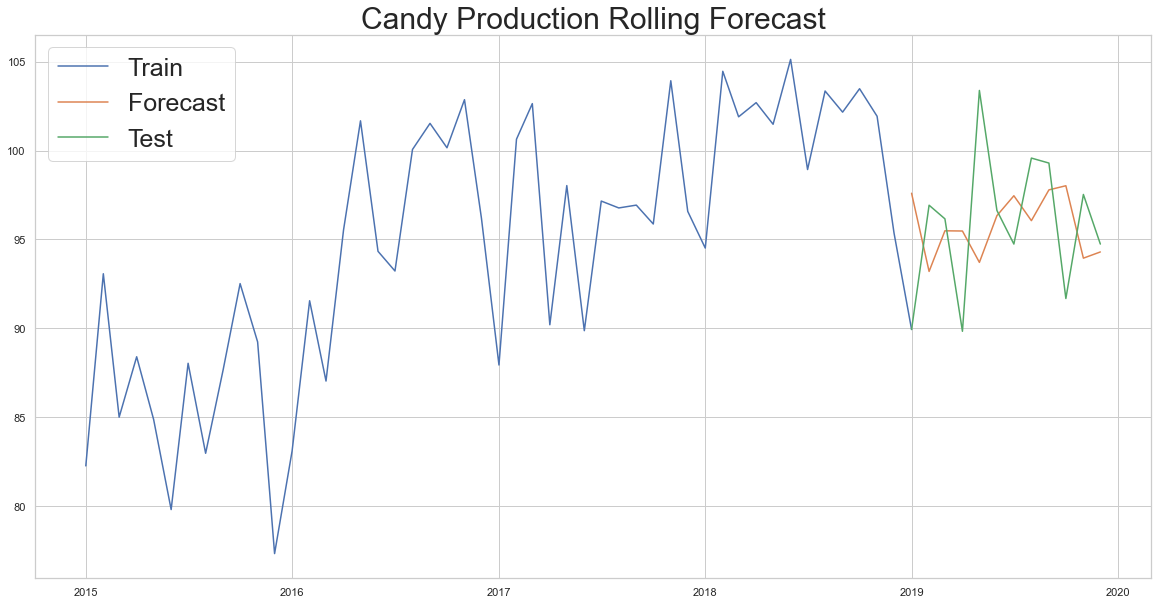

In [98]:
plt.figure(figsize=(20, 10))
plt.title('Candy Production Rolling Forecast', fontsize=30)
plt.plot(train, label='Train')
plt.plot(rolling_fcast['predictions'], label='Forecast')
plt.plot(test, label='Test')

print(f'Mean Squared Error: {rolling_fcast["mse"]}')
print(f'Root Mean Squared Error: {rolling_fcast["rmse"]}')
print(f'Mean Absolute Error: {rolling_fcast["mae"]}')
plt.legend(fontsize=25)
plt.show()

In [14]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [15]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:707.3622144346217
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:530.4935603477572
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:335.05939571119353
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1450.63986134285
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:340.2373210797209
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:319.8826012593238
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:236.39146589414705
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1381.2927884965543
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:623.4850543076103
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:465.616517449055
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:320.15979927354994
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1405.0069336893057
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:332.4456469261695
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:305.07411584769073
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:232.4822286810967
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1363.3003237101464
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:377.3992609523082
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:299.1120491790658
ARIMA

In [33]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0976      0.366     -0.267      0.790      -0.814       0.619
ma.L1         -0.6247      0.243     -2.573      0.010      -1.101      -0.149
ar.S.L12      -0.6109      0.200     -3.061      0.002      -1.002      -0.220
sigma2        21.4752      6.960      3.086      0.002       7.834      35.116


In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                Cantidad_siniestros   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -100.481
Date:                            Mon, 09 Nov 2020   AIC                            208.962
Time:                                    18:00:44   BIC                            215.067
Sample:                                01-01-2015   HQIC                           211.044
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0976      0.366     -0.267      0.790      -0.814       0.619
ma.L1         -0.6247      0.243     -2.573      0.010      -1.101      -0.149
ar.S.L12      -0.6109      0.200     -3.061      0.002      -1.002      -0.220
sigma2        21.4752      6.960      3.086      0.002       7.834      35.116
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.34
Prob(Q):                               nan   Prob(JB):                         0.84
Heteroskedasticity (H):               0.62   Skew:                             0.24
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

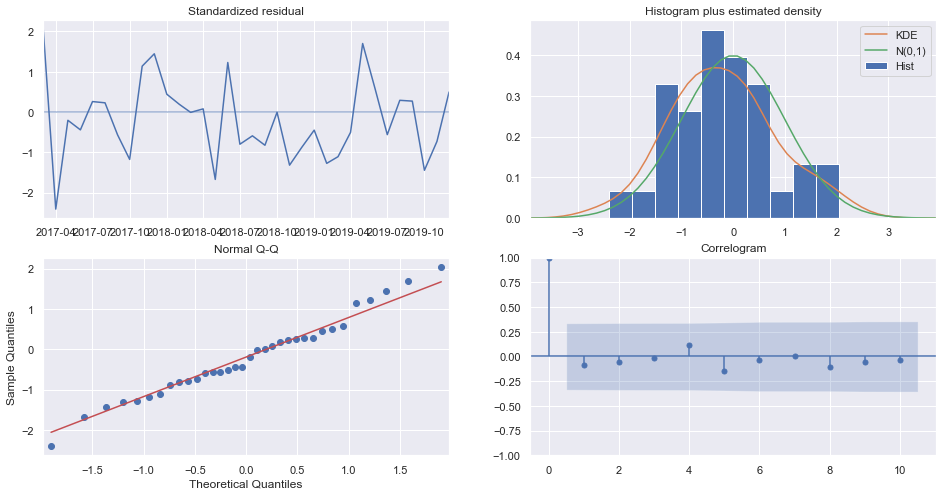

In [35]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

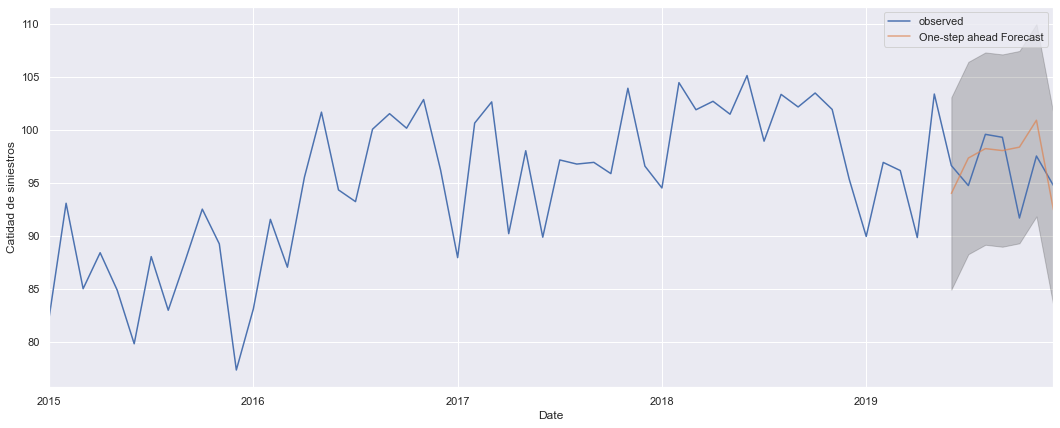

In [36]:
pred = results.get_prediction(start=pd.to_datetime('2019-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(18, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Catidad de siniestros')
plt.legend()
plt.show()

In [37]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-06-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 11.23


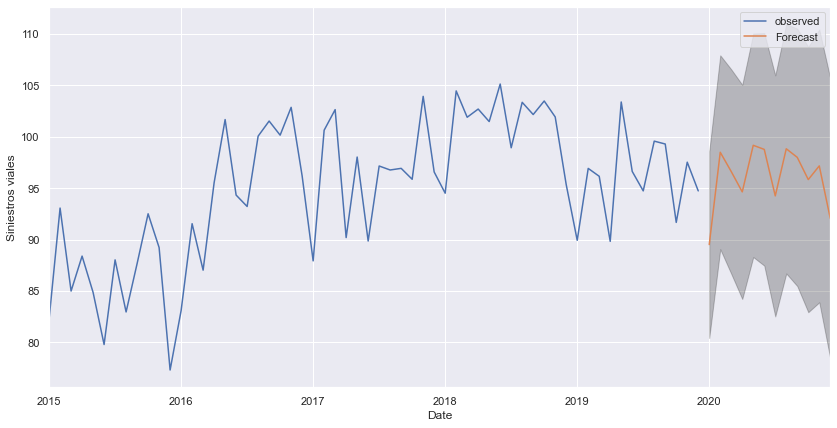

In [38]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Siniestros viales')
plt.legend()
plt.show()

In [39]:
pred_uc.predicted_mean

2020-01-01    89.520145
2020-02-01    98.499251
2020-03-01    96.618494
2020-04-01    94.644823
2020-05-01    99.175355
2020-06-01    98.777034
2020-07-01    94.254784
2020-08-01    98.837306
2020-09-01    98.002244
2020-10-01    95.841061
2020-11-01    97.172305
2020-12-01    92.067335
Freq: MS, dtype: float64

In [40]:
pred_ci

,lower Cantidad_siniestros,upper Cantidad_siniestros
2020-01-01,80.437400,98.602891
2020-02-01,89.072724,107.925778
2020-03-01,86.675531,106.561458
2020-04-01,84.229724,105.059922
2020-05-01,88.306873,110.043837
2020-06-01,87.473503,110.080566
2020-07-01,82.532322,105.977246
2020-08-01,86.710379,110.964233
2020-09-01,85.483914,110.520575
2020-10-01,82.943198,108.738923
